# 通し課題模範解答 分類編 DAY 1
- kaggle の kickstarter project に関して，成功・失敗を予測するモデルを作成する
    - https://www.kaggle.com/kemical/kickstarter-projects?select=ks-projects-201801.csv
- DAY 1 では，以下を行う
    - データの読み込み
    - データの基礎集計
    - 有効な説明変数の選択
    - データの可視化及び欠損値・異常値の処理
    - 質的変数の処理
    - ロジスティック回帰の利用
    - 識別精度の算出（検証については DAY 2）

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## データの読み込み

In [2]:
df = pd.read_csv('../data/ks-projects-201801.csv', index_col='ID')

- 各列の概略は以下の通りである．
    - ID: 各プロジェクトに固有の ID である．誤って説明変数に利用しないように，`index_col='ID'`として行名に固定してしまうのが良い（後述）．
    - name: プロジェクトの名称
    - category: プロジェクトの小分類
    - main_category: プロジェクトの大分類
    - currency: プロジェクトで集められた支援金の通貨単位
    - deadline: プロジェクトの終了期日
    - goal: プロジェクトにおける支援金の目標額（currency で指定された通貨単位で換算）
    - launched: プロジェクトの開始日時
    - pledged: プロジェクトで実際に集められた支援額
    - state: プロジェクトのステータス（成功・失敗など）
    - backers: プロジェクトの支援者数
    - country: プロジェクトの主体の所属国
    - usd pledged: pledged をある時点でのレートで USD 換算したもの（明らかに誤っている値が多い）
    - usd_pledged_real: pledged をある時点でのレートで USD 換算したもの（usd pledged とは異なり，明らかに誤っている値は見られない）
    - usd_goal_real: goal をある時点でのレートで USD 換算したもの

In [3]:
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### （参考）ks-projects-201612.csv の読み込み
- `encoding="ISO-8859-1"` を指定する必要がある

In [4]:
df2 = pd.read_csv('../data/ks-projects-201612.csv', encoding="ISO-8859-1")

/Users/mizoguchi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df2.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


## データの基礎集計

### データフレームの概要
- pandas.DataFrame の info メソッドを利用する

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 1000002330 to 999988282
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              378657 non-null  object 
 1   category          378661 non-null  object 
 2   main_category     378661 non-null  object 
 3   currency          378661 non-null  object 
 4   deadline          378661 non-null  object 
 5   goal              378661 non-null  float64
 6   launched          378661 non-null  object 
 7   pledged           378661 non-null  float64
 8   state             378661 non-null  object 
 9   backers           378661 non-null  int64  
 10  country           378661 non-null  object 
 11  usd pledged       374864 non-null  float64
 12  usd_pledged_real  378661 non-null  float64
 13  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(1), object(8)
memory usage: 43.3+ MB


### 連続変数の基礎集計
- pandas.DataFrame の describe メソッドを利用する

In [7]:
df.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


### （参考）離散変数の基礎集計
- pandas.Series の value_counts メソッドを利用する
    - ただし，カテゴリ数が大きいと省略されてしまうため，非推奨

In [8]:
# for col, dtype in df.dtypes.items():
#     if dtype == 'object':
#         print(col)
#         display(df[col].value_counts())

## 有効な説明変数の選択
以下は，説明変数として利用するのには不適切である．
- ID: 基本的に説明変数として利用しない．例えば，番号の若いデータには正例，そうでないデータには負例が集められているなど，恣意的に決定された値であることがある．その場合，リーケージに直結するため，説明変数として利用しないことが適切である．ID は，データフレームの作成時にインデックスナンバーとして読み込んでしまえば，誤って説明変数として利用することがないため安全である．
- pledged: プロジェクト終了時に判明する説明変数であり，リーケージを引き起こすため，利用しない．
- backers: プロジェクト終了時に判明する説明変数であり，リーケージを引き起こすため，利用しない．
- usd pledged: プロジェクト終了時に判明する説明変数であり，リーケージを引き起こすため，利用しない．
- usd_pledged_real: プロジェクト終了時に判明する説明変数であり，リーケージを引き起こすため，利用しない．
- goal: usd_goal_real と重複している．こちらは，通貨単位がバラバラなので利用しづらいと判断して削除．
- state: 目的変数である．削除はしない．

In [9]:
df = df.drop(columns=['pledged', 'backers', 'usd pledged', 'usd_pledged_real', 'goal'])

In [10]:
df.head()

,name,category,main_category,currency,deadline,launched,state,country,usd_goal_real
ID,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,US,19500.00


また，launched と deadline から，期間を表す変数 period を作成する

In [11]:
# 日時に関する変数を TimeStamp に変換
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])

In [12]:
# 期間の変数を作成
df['period'] = (df['deadline'] - df['launched']).dt.days 

## データの可視化及び欠損値・異常値の処理

### 連続変数の可視化及び異常値の処理
- seaborn の pairplot によって散布図行列を描画する
    - 描画には数分ほど時間がかかる場合がある

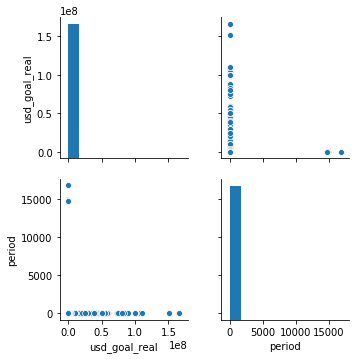

In [13]:
sns.pairplot(df)

散布図行列から，以下のことがわかる．
- period が 10000 以上のデータが数件 -> 異常値として除去

In [14]:
df = df[df['period'] < 10000] # 異常値の除去

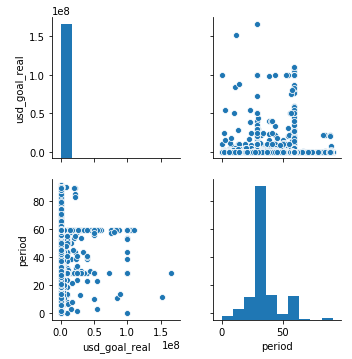

In [15]:
sns.pairplot(df) # 再描画

- ヒストグラムから，usd_goal_real は右に大きく歪んだ分布を描くことがわかる -> 対数変換を検討

/Users/mizoguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


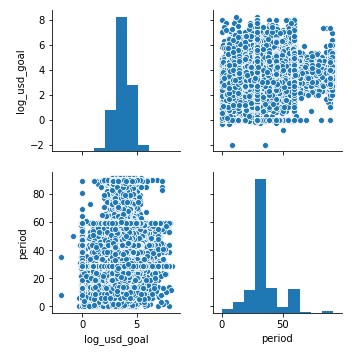

In [16]:
epsilon = 1e-5 # 対数変換の際に負の無限大に発散しないようにフロアリングするパラメータ
df['log_usd_goal'] = df['usd_goal_real'].apply(lambda x: np.log10(x + epsilon))

sns.pairplot(df[['log_usd_goal', 'period']])

### 離散変数の可視化，変数選択，及び異常値の処理
- state に関する円グラフを表示する

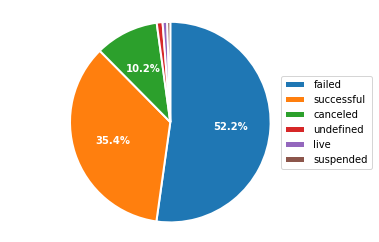

In [17]:
per_state = round(df['state'].value_counts() / len(df['state']) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(4,4))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()

成功（successful）と失敗（failed）以外のデータを除外する

In [18]:
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]

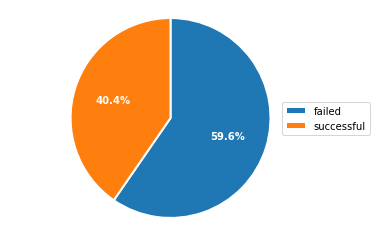

In [19]:
# 再描画
per_state = round(df['state'].value_counts() / len(df['state']) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(4,4))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()

続いて，離散変数同士の関連性を見る．下記では，連関係数を用いた議論を行うが，講座範囲外であるためクロス集計表の目視によって変数選択をしても十分である．

In [20]:
# object 型の変数名を表示
for col, dtype in df.dtypes.items():
    if dtype == 'object':
        print(col)

name
category
main_category
currency
state
country


以下について，クロス集計表を作成し，[連関係数](https://qiita.com/shngt/items/45da2d30acf9e84924b7#クラメールの連関係数)を算出
- category と main_category
- currency と country

In [21]:
# 連関係数を求める関数
def cramer_coef(x):
    chi2 = st.chi2_contingency(x)[0]
    return np.sqrt(chi2 / x.sum() / (min(x.shape) - 1))

In [22]:
# category vs main_category
ct_category = pd.crosstab(df['category'], df['main_category'])
cramer_coef(ct_category.to_numpy())

0.9862372840283602

非常に大きな連関係数が得られたため，片方の変数を用いれば十分であると判断する．変数選択の基準としては以下が考えられる．
- より細かな category を採用し，カテゴリ数削減のためにまとめる
- main_category を採用する

今回は簡単のため，後者とする

In [23]:
df = df.drop(columns=['category'])

In [24]:
# country vs currency
ct_country = pd.crosstab(df['country'], df['currency'])
cramer_coef(ct_country.to_numpy())

0.9995956562579831

非常に大きな連関係数が得られたため，片方の変数を用いれば十分であると判断する．変数選択の基準としては以下が考えられる．
- country を採用する
- currency を採用する

この状況では判断が難しいので，後で判断することにする

### 欠損値の処理

In [25]:
df.isnull().sum()

name             3
main_category    0
currency         0
deadline         0
launched         0
state            0
country          0
usd_goal_real    0
period           0
log_usd_goal     0
dtype: int64

name 列から後ほど特徴量を作成することを考慮して，行を削除

In [26]:
df = df.dropna(axis=0)

In [27]:
# 再表示
df.isnull().sum()

name             0
main_category    0
currency         0
deadline         0
launched         0
state            0
country          0
usd_goal_real    0
period           0
log_usd_goal     0
dtype: int64

In [28]:
for col, dtype in df.dtypes.items():
    if dtype == 'object':
        print(col)
        display(df[col].value_counts())

name


New EP/Music Development                      15
Music Video                                   11
New EP / Music Development                    10
Debut Album                                    9
Reflections                                    9
                                              ..
Know Thy Neighbor                              1
Booze & Ballet Choreographic project           1
ALONE IN SPACE                                 1
Salad Bowls: The life and story of a tree.     1
The Value of a Man                             1
Name: name, Length: 329594, dtype: int64

main_category


Film & Video    56526
Music           45949
Publishing      35445
Games           28520
Technology      27050
Art             25640
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

currency


USD    261509
GBP     29475
EUR     14378
CAD     12375
AUD      6621
SEK      1510
MXN      1411
NZD      1274
DKK       929
CHF       652
NOK       584
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64

state


failed        197716
successful    133956
Name: state, dtype: int64

country


US      261358
GB       29453
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

country 列に`N,0"`なる不明な値があるので，分析する

In [29]:
df[df['country'] == 'N,0"']['currency'].value_counts()

USD    151
GBP     22
EUR     21
AUD      5
CAD      5
DKK      3
NOK      2
SEK      1
Name: currency, dtype: int64

country は currency と強い連関があったため，country 列を削除しても良いと判断する

In [30]:
df = df.drop(columns='country')

## 質的変数の処理
現状，質的変数として残存しているのは以下である
- name: 単語数を抽出
- main_category: ワンホットベクトルに変換
- currency: ワンホットベクトルに変換
- state: バイナリに変換

In [31]:
df['n_words'] = df['name'].apply(lambda x: len(str(x).split(' ')))

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 1000002330 to 999988282
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   name           331672 non-null  object        
 1   main_category  331672 non-null  object        
 2   currency       331672 non-null  object        
 3   deadline       331672 non-null  datetime64[ns]
 4   launched       331672 non-null  datetime64[ns]
 5   state          331672 non-null  object        
 6   usd_goal_real  331672 non-null  float64       
 7   period         331672 non-null  int64         
 8   log_usd_goal   331672 non-null  float64       
 9   n_words        331672 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 27.8+ MB


In [33]:
df = df.drop(columns=['name', 'deadline', 'launched'])

In [34]:
df = pd.get_dummies(df, drop_first=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 1000002330 to 999988282
Data columns (total 32 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   usd_goal_real               331672 non-null  float64
 1   period                      331672 non-null  int64  
 2   log_usd_goal                331672 non-null  float64
 3   n_words                     331672 non-null  int64  
 4   main_category_Comics        331672 non-null  uint8  
 5   main_category_Crafts        331672 non-null  uint8  
 6   main_category_Dance         331672 non-null  uint8  
 7   main_category_Design        331672 non-null  uint8  
 8   main_category_Fashion       331672 non-null  uint8  
 9   main_category_Film & Video  331672 non-null  uint8  
 10  main_category_Food          331672 non-null  uint8  
 11  main_category_Games         331672 non-null  uint8  
 12  main_category_Journalism    331672 non-null  uint8  
 13  ma

In [36]:
# 対数変換前の数値は削除
df = df.drop(columns=['usd_goal_real'])

In [37]:
# 作成したデータフレームを保存
df.to_csv('../data/df_classification.csv')

## ロジスティック回帰

In [38]:
X = df.drop(columns=['state_successful'])
y = df['state_successful']
lr_clf = SGDClassifier(loss='log', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
lr_clf.fit(X, y)

SGDClassifier(loss='log', max_iter=10000, random_state=1234)

## 識別精度の算出
- 検証精度の算出については，DAY2以降で取り扱う

In [39]:
y_predicted = lr_clf.predict(X)

In [40]:
acc = accuracy_score(y, y_predicted)
precision = precision_score(y, y_predicted)
recall = recall_score(y, y_predicted)
f_1 = f1_score(y, y_predicted)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.654
Precision: 0.584
Recall: 0.496
F1: 0.536
